[View in Colaboratory](https://colab.research.google.com/github/assaflehr/language-style-transfer/blob/master/notebooks/keras_nlp.ipynb)

>>[Keras accuracy/performace limitations](#scrollTo=Og2XNK-_53VP)

>[Performace caution :](#scrollTo=Og2XNK-_53VP)

>>[Pretraining autoencoder or LM will surely help.](#scrollTo=Og2XNK-_53VP)

>>>[LSTM](#scrollTo=Og2XNK-_53VP)

>>>[Tip to self:](#scrollTo=Og2XNK-_53VP)

>>>[For David: example of how to clone, then use from github](#scrollTo=OrKzdh71sBKm)

>[Some params](#scrollTo=MBAgWVvXycpF)

>[Dataset](#scrollTo=wwc6_EHFD_Ir)

>[Model defintion](#scrollTo=BWVEcaeF6DBR)

>[compile](#scrollTo=VTobPYftYvQC)

>[Sample and show sample](#scrollTo=xh5FwdLGU2n3)

>[TRAINING](#scrollTo=9s0-8EJi6AG1)

>[SAVE LOAD MODEL](#scrollTo=QOjAoPF-gAqx)

>[Error analysis](#scrollTo=XvIkFOWy55ov)

>>[Error of style disc.](#scrollTo=8QaOXXjUAwVH)

>[FAQ and wierd exceptions](#scrollTo=E2yLpQu4mvAS)



## Keras accuracy/performace limitations
 
# Performace caution :
G training epoc (250x64 rows) 

type|RNN|bidi?|time
--|--
CPU|LSTM|Y| 15 min|
GPU|LSTM|Y| 75s| (slower but more-accurate)
GPU|CuDNNLSTM|Y| 42s
GPU|CuDNNLSTM|N| 35s






## Pretraining autoencoder or LM will surely help.

see late review here: https://thegradient.pub/author/sebastian
and autoencoder (which is less recommended than LM here: "Semi-supervised Sequence Learning" 2015. They use one RNN for both encoder and decoder)


###   LSTM 
* CuDNNLSTM trains on GPU , but does not support the attributes: dropout,recurrent_dropout,which are the STOA regulaizers. This is cuda problem, and even native TF does not support it
Hard to compare only that. all G (with dense and more...) takes 35s on GPU. on CPU ???
* Make LSTM deep instead of bigger for linear instead of quadratic growth in compuation. when doing so, add skip connection to 2nd/3rd/... layers
* large vocab size means huge softmax, means slow runtime. to optimize training NCE loss replaces softmax on train-time (TF only)

### Tip to self:
* manually check loss value on one sample (predict vs gt). From doing this, I saw <s> was not given one-hot-value

In [2]:
%load_ext autoreload
%autoreload 2




import tensorflow as tf
import sys
import numpy as np

# colab requirements
!pip install spacy
!pip install pydrive   #to save to google-drive
# our github proj!
!rm -r paraphraser  #remove previous github copy if needed
!git clone https://github.com/delkind/paraphraser.git
sys.path.append('paraphraser/src')





#usage example
from utils.persistency import Persistency    #your code here!!!
from models import D_G_Model

#!ps -ef | grep python




    100% |████████████████████████████████| 17.6MB 1.8MB/s 
    100% |████████████████████████████████| 92kB 18.6MB/s 
    100% |████████████████████████████████| 1.2MB 13.5MB/s 
    100% |████████████████████████████████| 51kB 16.1MB/s 
    100% |████████████████████████████████| 194kB 18.6MB/s 
    100% |████████████████████████████████| 153kB 19.1MB/s 
    100% |████████████████████████████████| 604kB 16.4MB/s 
    100% |████████████████████████████████| 51kB 15.4MB/s 
    100% |████████████████████████████████| 389kB 16.0MB/s 
    100% |████████████████████████████████| 143kB 19.7MB/s 
  Running setup.py bdist_wheel for spacy ... - \ | / - \ |

 / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - done
  Stored in directory: /content/.cache/pip/wheels/fb/00/28/75c85d5135e7d9a100639137d1847d41e914ed16c962d467e4
  Running setup.py bdist_wheel for murmurhash ... - \ | / done
  Stored in directory: /content/.cache/pip/wheels/b8/94/a4/f69f8664cdc1098603df44771b7fec5fd1b3d8364cdd83f512
  Running setup.py bdist_wheel for cymem ... - \ | done
  Stored in directory: /content/.cache/pip/wheels/55/8d/4a/f6328252aa2aaec0b1cb906fd96a1566d77f0f67701071ad13
  Running setup.py bdist_wheel for preshed ... - \ | / - \ | done
  Stored in directory: /content/.cache/pip/wheels/8f/85/06/2d132fb649a6bbcab22487e4147880a55b0dd0f4b18fdfd6b5
  Running setup.py bdist_wheel for thinc ..

 | / - \ | / done
  Stored in directory: /content/.cache/pip/wheels/f8/b1/86/c92e4d36b690208fff8471711b85eaa6bc6d19860a86199a09
  Running setup.py bdist_wheel for msgpack-python ... - \ | / done
  Stored in directory: /content/.cache/pip/wheels/d5/de/86/7fa56fda12511be47ea0808f3502bc879df4e63ab168ec0406
Successfully built spacy murmurhash cymem preshed thinc pathlib ujson dill regex wrapt cytoolz msgpack-python
    100% |████████████████████████████████| 993kB 7.2MB/s 
  Running setup.py bdist_wheel for pydrive ... - \ done
  Stored in directory: /content/.cache/pip/wheels/fa/d2/9a/d3b6b506c2da98289e5d417215ce34b696db856643bad779f4
Successfully built pydrive
rm: cannot remove 'paraphraser': No such file or directory
Cloning into 'paraphraser'...
remote: Counting objects: 89, done.
remote: Compressing objects: 100% (55/55), done.
remote: Total 89 (delta 38), reused 71 (delta 24), pack-reused 0
Unpacking objects: 100% (89/89), done.


Using TensorFlow backend.


# Dataset

In [3]:

#dataset = BibleDataset(URL_ROOT, ["asv", "bbe", "dby", "kjv", "wbt", "web", "ylt"], CSV_EXT)
# differences: very old , formal: ylt . very dynamic, simple words: bbe, middle ground (5 similiar wbt)
from dataset.bible import BibleDataset

dataset = BibleDataset(files=["bbe", "ylt"]) 



4784128/4779319 [==============================] - 0s 0us/step


In [0]:
import keras
from keras.callbacks import ReduceLROnPlateau




batch_size = 64



class LossHistory(keras.callbacks.Callback):
    def __init__(self):
      self.losses = {'loss':[],'val_loss':[]}
      
    #def on_train_begin(self, logs={}):
    #  pass  
    
    def on_epoch_end(self, batch, logs={}):
      for loss in ['loss','val_loss']:
        self.losses[loss].append(logs.get(loss))
        
np.random.seed(42)


import matplotlib.pyplot as plt 

# summarize history for loss
def plt_losses(loss_history,title,with_val=False):
  plt.plot(loss_history.losses['loss'][:])
  if with_val:
    plt.plot(loss_history.losses['val_loss'][:])
  plt.title(title)
  med=0.1 if len(loss_history.losses['loss'])<1 else np.median(loss_history.losses['loss'])
  plt.ylim(ymin=-0.1)
  plt.ylim(ymax=med+1.5)
  plt.ylabel('loss')
  plt.xlabel('batchse')
  plt.legend(['train', 'val'], loc='upper right')
  

def plt_all(with_val=True):  
  plt.figure(figsize=(14,4))
  plt.subplot(131) #numrows, numcols, fignum
  plt_losses(loss_history,'g loss',with_val)  
  plt.subplot(132)
  plt_losses(loss_history_d,'d loss',with_val)  
  plt.subplot(133)
  plt_losses(loss_history_adv,'adv loss',with_val) 
  plt.show()


#  
loss_history = LossHistory()
loss_history_d = LossHistory()
loss_history_adv = LossHistory()  
#plt_all()



def train_g(g, steps, validation_steps=1):
    g.fit_generator(dataset.gen_g(dataset.train, batch_size),
                        steps,
                        validation_steps=validation_steps,
                        validation_data=dataset.gen_g(dataset.val, batch_size),
                        callbacks=[loss_history],
                        verbose=0 if steps < 10 else 1,
                        max_queue_size=50,
                        workers=2
                        )

    # model.fit([x_train, x_train_d], y_train,


def train_d(d, steps, validation_steps=1):
    # %time d_encoder_model.set_weights(encoder_model.get_weights())
    d.fit_generator(dataset.gen_d(dataset.train, batch_size),
                    steps,
                    validation_steps=validation_steps,
                    validation_data=dataset.gen_d(dataset.val, batch_size),
                    verbose=0 if steps < 20 else 1,
                    max_queue_size=50,
                    workers=2,
                    callbacks=[loss_history_d])
    # d.fit(x_train, style_train,


def train_adv(adv_model, steps, validation_steps=1):
    # %time classifier_model.set_weights(d_classifier_model.get_weights())

    adv_model.fit_generator(dataset.gen_adv(dataset.train, batch_size),
                            steps,
                            validation_steps=validation_steps,
                            validation_data=dataset.gen_adv(dataset.val, batch_size),
                            max_queue_size=50,
                            workers=2,
                            verbose=0 if steps < 20 else 1,
                            callbacks=[loss_history_adv])
 
  


In [0]:
from models import D_G_Model

model = D_G_Model(num_encoder_tokens=len(dataset.word2index),
                      num_decoder_tokens=len(dataset.word2index),  #from dataset 3628
                      style_out_size=len(dataset.style2index), #from dataset 2
                      cuddlstm=True,
                      latent_dim = 512, #twice the default. make it stronger! but slower
                      bidi_encoder = True,
                      adv_loss_weight=1.0,)
model.build_all()


  
  

# Sample and show sample

In [6]:
from decoder import SamplingDecoder
sampler= SamplingDecoder(model)        
#sampler.show_sample(dataset,'train',sample_ids=[0],teacher_forcing=True)           
#sampler.show_sample(dataset,'val',sample_ids=[0],teacher_forcing=False)

#show_sample('train',sample_id=[0,1,2],teacher_forcing=False) 

# test tokenizer, by looking at the originals:
#orogi https://raw.githubusercontent.com/scrollmapper/bible_databases/master/csv/t_bbe.csv
#At the first God made the heaven and the earth.
#And the earth was waste and without form; and it was dark on the face of the deep: and the Spirit of God was moving on the face of the waters.
#"And God said, Let there be light: and there was light."

#https://raw.githubusercontent.com/scrollmapper/bible_databases/master/csv/t_ylt.csv
#In the beginning of God's preparing the heavens and the earth --
#"the earth hath existed waste and void, and darkness `is' on the face of the deep, and the Spirit of God fluttering on the face of the waters,"
#"and God saith, `Let light be;' and light is."



############################## verb 0 ##############################

##encoder_input[<bbe>]: at the first god made the heaven and the earth .
decoder TF     [<bbe>]: supports stronger in mourned certain supports latter being being being pronounced pronounced shrine eleazar eleazar eleazar eleazar eleazar eleazar eleazar eleazar eleazar eleazar eleazar fifteenth fifteenth fifteenth fifteenth fifteenth fifteenth fifteenth fifteenth fifteenth fifteenth fifteenth fifteenth fifteenth fifteenth fifteenth fifteenth fifteenth fifteenth fifteenth fifteenth fifteenth fifteenth fifteenth fifteenth fifteenth fifteenth fifteenth fifteenth fifteenth fifteenth fifteenth fifteenth fifteenth fifteenth fifteenth fifteenth fifteenth
gold label     [<bbe>]: at the first god made the heaven and the earth .
decoder TF     [<ylt>]: lamps lamps lamps overtake flesh flesh lamps asshur asshur overtake substance substance hin opinion fate fate fate eleazar eleazar eleazar eleazar eleazar eleazar fifteenth fifte

# long  pre-TRAINING

In [7]:
train_size = len(dataset.index2style) * (dataset.train[1] - dataset.train[0])
epoc = int(train_size/batch_size)
print ('epoc is of',epoc,'of batches',batch_size,'total train_size',train_size)


######## PRE TRAINING ##########################

load_id='1kxKYkP0iojqYZ6JY5kNvhdrGSjMTqYMX'
if load_id:
  pers=Persistency()
  pers.load_weights_from(model.get_models(),model.get_model_names(),folder='from_gdrive/',download_gdrive_id=load_id)
  pre_train=False
else:
  pre_train= True
  
if (pre_train):
  for i in range(20):
    print ('EPOC',i)
    train_g(model.g,int(epoc),validation_steps=int(epoc/10))  #pretrain


    l=loss_history.losses['loss'][-1:][0]
    plt_all()
    sampler.show_sample(dataset,'train',[0],teacher_forcing=False) 
    sampler.show_sample(dataset,'train',[0],teacher_forcing=True)
    if l<0.5: #0.5 is good value for 20 length sentences. for longer, NOT!
      print ('early break at break at',l,'epoc',i)
      break
    
  
  for i in range(0):
    train_d(model.d,epoc,validation_steps=100)
    l=loss_history_d.losses['loss'][-1:][0]
    if l<2:
      print ('early break at break at',l,'epoc',i)
      break

  

loaded into  from_gdrive/
loading from_gdrive//encoder_model.h5
loading from_gdrive//decoder_sampling_model.h5
loading from_gdrive//d.h5
loading from_gdrive//g.h5
loading from_gdrive//g_d.h5
load from  from_gdrive/ complete. Make sure you already compiled the model and set optimizers


In [8]:
sampler.show_sample(dataset,'train',[0],teacher_forcing=False) 
sampler.show_sample(dataset,'train',[0],teacher_forcing=True)

############################## verb 0 ##############################

##encoder_input[<bbe>]: at the first god made the heaven and the earth .
decoder sample [<bbe>]: at the first word the earth takes the heaven and are . <end>
gold label     [<bbe>]: at the first god made the heaven and the earth .
decoder sample [<ylt>]: at the first one made the heavens and heaven was . <end>
gold label     [<ylt>]: in the beginning of god 's <OOV> the heavens and the earth

##encoder_input[<ylt>]: in the beginning of god 's <OOV> the heavens and the earth
decoder sample [<bbe>]: in the hearing of the king 's <OOV> earth and the heavens <end>
gold label     [<bbe>]: at the first god made the heaven and the earth .
decoder sample [<ylt>]: in the beginning of god 's <OOV> the heavens and the earth answered me <end>
gold label     [<ylt>]: in the beginning of god 's <OOV> the heavens and the earth
############################## verb 0 ##############################

##encoder_input[<bbe>]: at the first

In [142]:

#Persistency().save_weights(model.get_models(),model.get_model_names(),save_to_gdrive=True) #not run yet....
# saving models/models_weights_2018-07-17_19-40-05.zip as id 1kxKYkP0iojqYZ6JY5kNvhdrGSjMTqYMX  

saving models/models_weights_2018-07-17_19-40-05.zip as id 1kxKYkP0iojqYZ6JY5kNvhdrGSjMTqYMX


## Long adverserial training

epoc contains  755 batches of 64
############################## epocs 0
0 of 39 small steps of size 19 please wait... 
20 of 39 small steps of size 19 please wait... 
############################## verb 0 ##############################

##encoder_input[<bbe>]: at the first god made the heaven and the earth .
decoder TF     [<bbe>]: at the first god made the heaven and the earth . <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end>
gold label     [<bbe>]: at the first god made the heaven and the earth .
decoder TF     [<ylt>]: at the first life life still life the life was . earth . . . <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <en

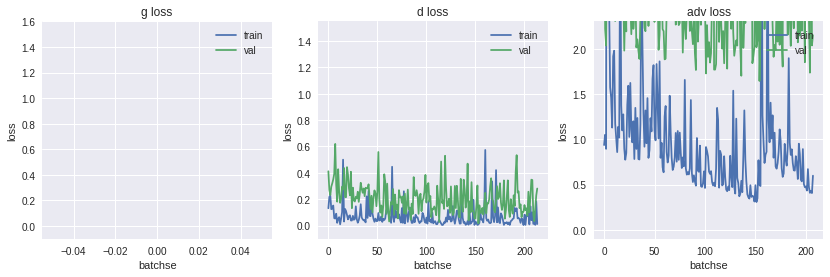

############################## epocs 1
0 of 39 small steps of size 19 please wait... 


In [0]:
print ('epoc contains ',epoc,'batches of', batch_size)
# 4 epocs of 1/10.  started well, then adv. start to be too-strong
# then 1/100
small_steps_d=1
small_steps_adv=19


for e in range(30):
  print ('#'*30,'epocs',e)
  for i in range(int(epoc/small_steps_adv)):
    if i % 20 ==0:print (i,'of',int(epoc/small_steps_adv),'small steps of size',small_steps_adv,'please wait... ')
    
    train_d(model.d,small_steps_d)
    while loss_history_d.losses['loss'][-1:][0]>0.5:
      train_d(model.d,small_steps_d)
    
    train_adv(model.g_d,small_steps_adv)
    while loss_history_d.losses['loss'][-1:][0]>0.3: #maybe less?
      train_adv(model.g_d,small_steps_adv)
      
  sampler.show_sample(dataset,'train'  ,sample_ids=[0,1],teacher_forcing=True)
  plt_all()
  if e%10==9:
    Persistency().save_weights(model.get_models(),model.get_model_names(),save_to_gdrive=True)
print ('done')



In [14]:
#train_adv(model.g_d,10000,1)

sampler.show_sample(dataset,'train'  ,sample_ids=[1],teacher_forcing=False)   #,8000+0
#train_g(model.g,100,1)
train_d(model.d,100)

############################## verb 1 ##############################

##encoder_input[<bbe>]: and the earth was waste and without form ; and it was dark on the face of the deep : and the spirit of god was moving on the face of the waters .
decoder sample [<bbe>]: and the earth was waste and there are the way ; like it dark by the face of the east : it is dark on clouds and on the face of the earth : <end>
gold label     [<bbe>]: and the earth was waste and without form ; and it was dark on the face of the deep : and the spirit of god was moving on the face of the waters .
decoder sample [<ylt>]: and the earth was waste and there is no ; like it like the light on the face of the earth : and thick clouds of dark and cloud on the ends of earth . <end>
gold label     [<ylt>]: the earth hath <OOV> waste and void , and darkness is ' on the face of the deep , and the spirit of god <OOV> on the face of the waters ,

##encoder_input[<ylt>]: the earth hath <OOV> waste and void , and darkness is 

# Error analysis

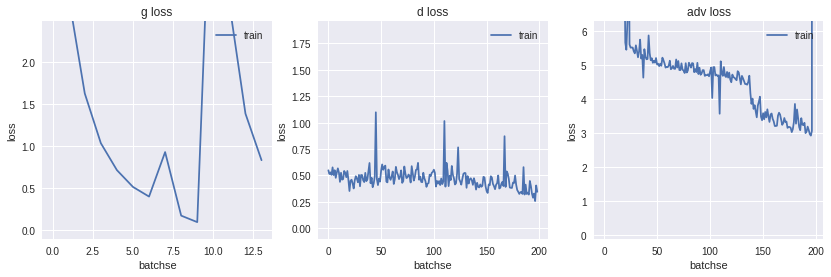

############################## verb 1 ##############################

##encoder_input[<bbe>]: and the earth was waste and without form ; and it was dark on the face of the deep : and the spirit of god was moving on the face of the waters .
decoder TF     [<bbe>]: the the of , , the , , and the the , , the the of the lord , the the lord , the , , , <end> <end> of the <end> , <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end>
gold label     [<bbe>]: and the earth was waste and without form ; and it was dark on the face of the deep : and the spirit of god was moving on the face of the waters .
decoder TF     [<ylt>]: the of the , , the , and the , the the , the of the lord , and the lord , the , , , lord of the lord , and <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end

In [34]:
#show_sample('test',sample_id=[0,1,2,999],teacher_forcing=False)   #,8000+0
#print (' VAL '*10)                          #TEst with FALSE
plt_all()
sampler.show_sample(dataset,'train'  ,sample_ids=[1],teacher_forcing=True)   #,8000+0

sampler.show_sample(dataset,'train'  ,sample_ids=[1],teacher_forcing=False)   #,8000+0


In [0]:
t

In [287]:



#a= model.predict([x_train[s:e], x_train_d[s:e]])
#for i in range(dataset.MAX_SEQUENCE_LENGTH):
#  best=np.argmax(a[0,i])
#  print (i,best,dataset.index2word[best],a[0,i,best],a[0,i,0])

#NEED TO FIX CODE HERE
from keras.losses import categorical_crossentropy
p=model.predict([x_val,x_val_d])
scores=K.eval(K.sum(categorical_crossentropy(K.constant(p), K.constant(y_val) ),axis=1))
worse_10 = scores.argsort()[::-1][:10]

for i in range(len(worse_10)):
  bad=worse_10[i]
  print (i,'arg',bad,'score',scores[bad],show_sample('val',False,bad))
  


ValueError: ignored

## Error of style disc.

In [211]:
### Error of style discriminator
x,y=next(gen(dataset.result.val,10,'d'))
print ('eval',d.evaluate(x,y))
p=d.predict(x)
for i in range(len(y)):
  print (i,'error',(abs(y[i][0]-p[i][0])),'gold',y[i],p[i],dataset.one_x_as_text(x[i]))





10/10 [==============================] - 0s 2ms/step
eval [0.6257959008216858, 0.8999999761581421]
0 actual 0.38546136 [0. 1.] [0.38546136 0.6145386 ] For I have kept the ways of the Lord; I have not been turned away in sin from my God.
1 actual 0.42803007 [0. 1.] [0.42803007 0.5719699 ] "And while she was still talking with the king, <oov> the prophet came in." <s> <s> <s> <s> <s> <s>
2 actual 0.31531385 [0. 1.] [0.31531385 0.6846862 ] "Then he gave a cry to the servant who was waiting on him and said, Put this woman out, and
3 actual 0.01998341 [1. 0.] [0.9800166  0.01998337] "And all the people come up after him, and the people are <oov> with <oov> and <oov> -- great joy,
4 actual 0.116271734 [0. 1.] [0.11627173 0.8837283 ] "Now the servants of David and <oov> had been out attacking a band of armed men, and they came back
5 actual 0.10636711 [0. 1.] [0.10636711 0.8936329 ] "He made them of liquid metal in the lowland of Jordan, at the way across the river, at <oov> between
6 actual 

In [0]:
why GANs work?
d classifies fake and real.
g is working to make fakes look more real.

# FAQ and wierd exceptions

* If you get exceptions related to cuda-lstm , inside the show_sample, but you actially not using it at all.  You will need to restart the notebook (thinking it's TF issue/bug)
* why the sampler without teacher-forcing emits garabage? if it emits the 1st word differently from teacher-forcing, it means that the models somehow got disconnected, or that you use wrong label (y1 should be one-hot of x1 not of x2)
* why the decoder shows bad sentences when my loss gets lower?  the loss should be **very** low before you start getting real results. typically values of g of less than 0.5

In [0]:
# Very slow training speed, is it generator next() which is slow?
%time gen= dataset.gen_adv(dataset.train, batch_size)
%time next(gen)
%time next(gen)
%time next(gen)
[x1,x2],[y1,y2]=next(gen)
print (x1.shape)  #20 batches per second

#for i in range(100): #batch-generation time is up to 50ms. means 10 batches is 0.5 seconds, means train step is 1sec only generation!
train_adv(model.g_d, 1000, validation_steps=1) #looked like 2-3min 180s, of which 100s are 